# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
import keras
keras.__version__

'2.6.0'

In [3]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random
import math 
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, plot_confusion_matrix, roc_auc_score
from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input, SeparableConv2D, ReLU, GlobalAvgPool2D,MaxPool2D,Add
from keras.models import Sequential, Model
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

**LOAD DATA**

In [5]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-11-04 01:48:15--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 74.125.129.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   143MB/s    in 1.5s    

2021-11-04 01:48:16 (143 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [6]:
# Unzipping Data
!gunzip flower_photos.tgz

In [7]:
!tar -xvf flower_photos.tar

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

**Plotting Images**

In [8]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [9]:
len(images) # Number of images

3670

In [10]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [11]:
image_size = 224 # Setting the size of the images
b_size = 32

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [12]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split = 0.2
)

In [13]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [14]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**Xception**

In [15]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
  x = BatchNormalization()(x)
  return x

In [16]:
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [17]:
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

In [18]:
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

In [19]:
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 5, activation = 'softmax')(x)
    
    return x

In [20]:
input = Input(shape = (image_size,image_size,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [21]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])

In [22]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test
                   , epochs=10, verbose=1, shuffle=True)

Epoch 1/10
92/92 [==============================] - 182s 2s/step - loss: 1.1674 - accuracy: 0.5284 - precision: 0.6579 - recall: 0.3324 - val_loss: 1.6063 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
92/92 [==============================] - 139s 2s/step - loss: 1.0222 - accuracy: 0.6005 - precision: 0.6960 - recall: 0.4627 - val_loss: 1.6053 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
92/92 [==============================] - 139s 2s/step - loss: 0.9288 - accuracy: 0.6366 - precision: 0.7250 - recall: 0.5257 - val_loss: 1.6051 - val_accuracy: 0.2449 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
92/92 [==============================] - 139s 2s/step - loss: 0.8901 - accuracy: 0.6546 - precision: 0.7488 - recall: 0.5618 - val_loss: 1.6296 - val_accuracy: 0.2449 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
92/92 [==============================] - 139s 2s/step - loss: 0.8

In [23]:
mpl.rcParams.update({'font.size': 10, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

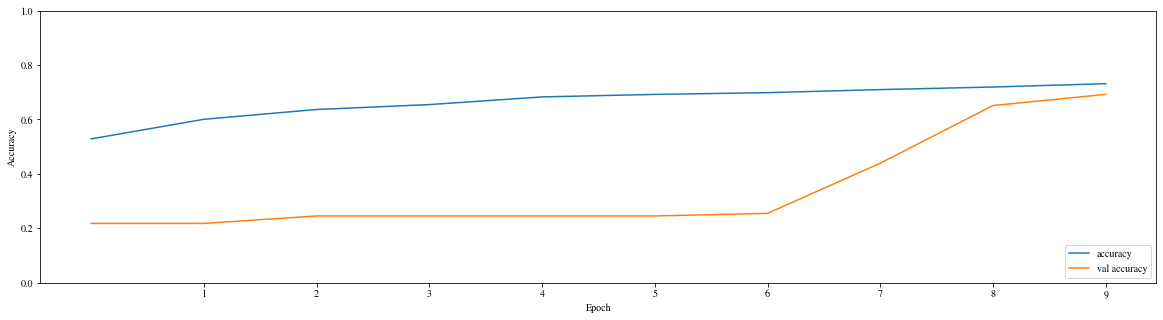

In [24]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,10)))
plt.ylim([0, 1])
plt.legend(loc='lower right')


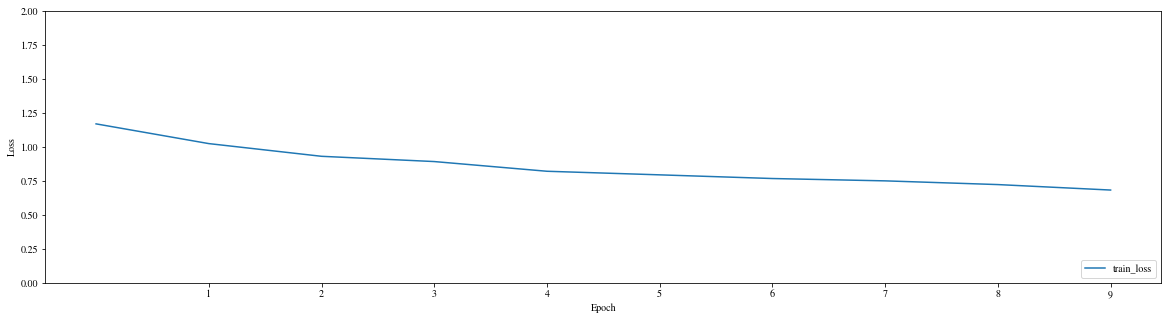

In [25]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(1,10)))
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [26]:
flower_gen_test.reset()
x_test, y_test = next(flower_gen_test)
for i in tqdm(range(int(len(flower_gen_test.labels)/b_size))):
  img, label = next(flower_gen_test)
  x_test = np.append(x_test, img, axis = 0)
  y_test = np.append(y_test, label, axis = 0)

print(x_test.shape,y_test.shape)

100%|██████████| 22/22 [00:10<00:00,  2.05it/s]

(731, 224, 224, 3) (731, 5)


In [27]:
#plt.figure(figsize=(10,5))
y_pred = model.predict(x_test)
#y_pred = model.predict(x_test).ravel()
#fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred)
auc_keras = roc_auc_score(y_test,y_pred,multi_class='ovr')
print("ROC AUC score OVR:" + str(auc_keras))
#plt.title("ROC AUC score:" + str(auc_keras))
#plt.plot(y_test,y_pred, marker = ".")
auc_keras = roc_auc_score(y_test,y_pred,multi_class='ovo')
print("ROC AUC score OVO:" + str(auc_keras))

ROC AUC score OVR:0.9132950431632612
ROC AUC score OVO:0.9132950431632612


The higher the AUC, the better performance of the model at distinguishing between the positives and negatives classes

**Final Scores**

Accuracy = $\frac{(TP+TN)}{(TP+FP+TN+FN)}$

Precision = $\frac{TP}{(TP+FP)}$

Recall =$\frac{TP}{(TP+FN)}$

In [28]:
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [30]:
flower_labels = flower_gen_train.class_indices.keys()
print(flower_labels)

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])


Normalized confusion matrix
[[0.6031746  0.0952381  0.12698413 0.00793651 0.16666667]
 [0.01117318 0.73743017 0.05027933 0.07821229 0.12290503]
 [0.015625   0.0390625  0.453125   0.015625   0.4765625 ]
 [0.02877698 0.05035971 0.05755396 0.76258993 0.10071942]
 [0.01257862 0.05660377 0.10691824 0.03773585 0.78616352]]


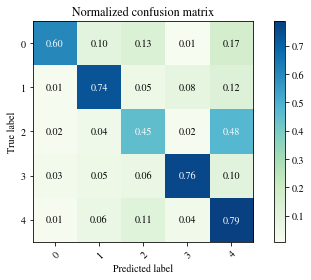

In [31]:
plot_confusion_matrix(y_test, y_pred, classes=np.r_[0,1,2,3,4], normalize=True, cmap=plt.cm.GnBu)

**Plot Evaluation**

In [32]:
model.save("07_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [33]:
def plot_example(X, y, y_pred=None):
# Create figure with 3 x 3 sub-plots.
  fig, axes = plt.subplots(3, 6)
  fig.set_size_inches(18,10)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  X, y = X[:18, ..., 0], y[:18]
  for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(X[i], alpha = 1)
    # Show true and predicted classes.
    if y_pred is None:
      xlabel = "True: {0}".format(y[i])
    else:
      xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])
    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
  plt.show()

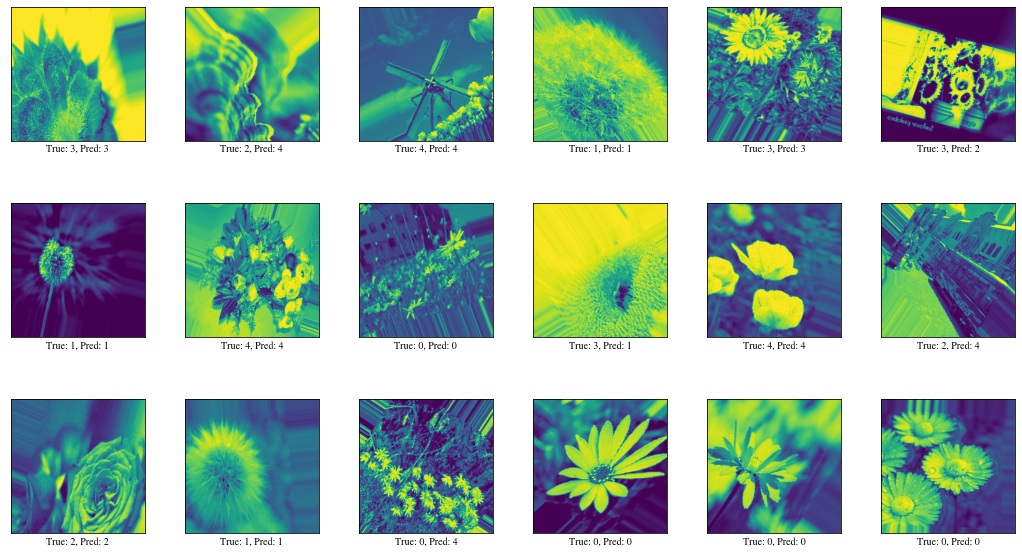

In [34]:
model = tf.keras.models.load_model('07_model.h5')
#%matplotlib inline
# Make prediction
predictions = model.predict(x_test)
# retrieve prediction indices
pred_y = np.argmax(predictions, axis=1)
# Plot some examples with model predictions
plot_example(x_test, y_test, y_pred)